In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns


az.style.use('arviz-darkgrid')

In [2]:
PRIMATE_DATA = 'milk.csv'
DATA_FOLDER = '../../data'

In [3]:
df = pd.read_csv(f'{DATA_FOLDER}/{PRIMATE_DATA}')
df.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


## Explanation of Columns

* kcal.per.g = kcal per gram of milk
* mass = average female body mass in kg
* neocortex.perc = percentage of total brain mass that is neocortex

In [5]:
df = df.dropna()

## Standardlize Variables

### Code 5.28

In [6]:
df['kcal.per.g_stan'] = (df['kcal.per.g'] - df['kcal.per.g'].mean()) / df['kcal.per.g'].std()
df['mass_stan'] = (df['mass'] - df['mass'].mean()) / df['mass'].std()
df['neocortex.perc_log'] = df['neocortex.perc'].apply(np.log)
df['neocortex.perc_stan'] = (df['neocortex.perc_log'] - df['neocortex.perc_log'].mean()) /  df['neocortex.perc_log'].std()

## First Model

In this model, we regress the kilocalaries per gram with the neocortex mass. 
$$
\begin{align*}
    K_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \beta_N \cdot N_i \\
    \alpha  & \sim N(0, 1) \\
    \beta_N & \sim N(0, 1) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

In [7]:
with pm.Model() as m_5_5_draft:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_N = pm.Normal('beta_N', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_N * df['neocortex.perc_stan'])
    K = pm.Normal('kilocal', mu=mu, sigma=sigma, observed=df['kcal.per.g_stan'])
    
    trace_5_5_draft = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 10 seconds.


## Prior Predictive Plots

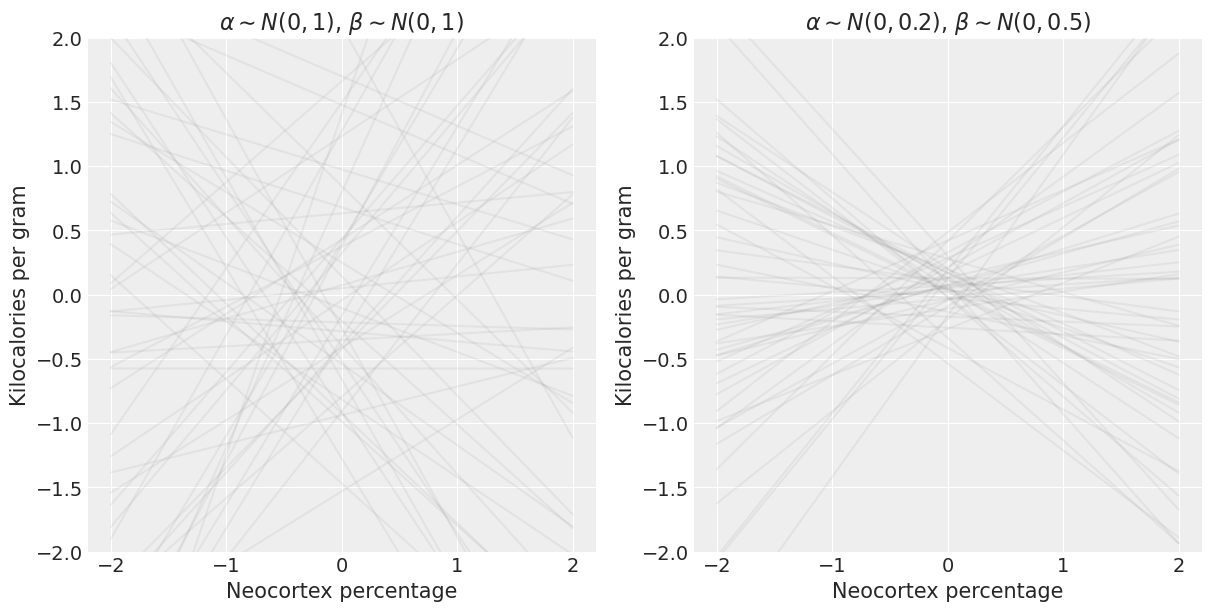

In [8]:
from scipy.stats import norm


N = 50

xvals = np.linspace(-2, 2, num=100)
a_1 = norm.rvs(loc=0, scale=1, size=N)
b_1 = norm.rvs(loc=0, scale=1, size=N)

a_2 = norm.rvs(loc=0, scale=0.2, size=N)
b_2 = norm.rvs(loc=0, scale=0.5, size=N)

fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(12, 6))

for i in range(N):
    line_1 = a_1[i] + b_1[i] * xvals
    line_2 = a_2[i] + b_2[i] * xvals
    
    ax_1.plot(xvals, line_1, color='grey', alpha=0.1)
    ax_2.plot(xvals, line_2, color='grey', alpha=0.1)
    
ax_1.set_xlabel('Neocortex percentage')
ax_1.set_ylabel('Kilocalories per gram')
ax_1.set_ylim(-2, 2)

ax_2.set_xlabel('Neocortex percentage')
ax_2.set_ylabel('Kilocalories per gram')
ax_2.set_ylim(-2, 2)

ax_1.set_title(r'$\alpha \sim N(0,1)$, $\beta \sim N(0, 1)$')
ax_2.set_title(r'$\alpha \sim N(0,0.2)$, $\beta \sim N(0, 0.5)$')

plt.show()

## Second Model

### Code 5.34

In [9]:
with pm.Model() as m_5_5:
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_N = pm.Normal('beta_N', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_N * df['neocortex.perc_stan'])
    K = pm.Normal('kilocal', mu=mu, sigma=sigma, observed=df['kcal.per.g_stan'])
    
    trace_5_5 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 10 seconds.


In [10]:
df_trace_5_5 = pm.trace_to_dataframe(trace_5_5)
df_trace_5_5.head()

,alpha,beta_N,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,mu__10,mu__11,mu__12,mu__13,mu__14,mu__15,mu__16
0,0.004868,-0.244272,1.130428,0.540462,0.118212,0.118212,-0.007925,-0.055597,0.366360,0.239642,0.300025,-0.098983,-0.115837,-0.227656,-0.003549,-0.148101,-0.198191,-0.109338,-0.331840,-0.303144
1,-0.143491,0.218910,0.904952,-0.623477,-0.245067,-0.245067,-0.132026,-0.089303,-0.467451,-0.353890,-0.408003,-0.050422,-0.035318,0.064891,-0.135948,-0.006404,0.038485,-0.041142,0.158258,0.132542
2,0.133216,0.256570,1.095494,-0.429344,0.014165,0.014165,0.146653,0.196725,-0.246476,-0.113379,-0.176802,0.242295,0.259999,0.377447,0.142057,0.293887,0.346498,0.253172,0.486876,0.456736
3,0.251880,0.330323,1.129717,-0.472392,0.098606,0.098606,0.269180,0.333646,-0.236958,-0.065600,-0.147255,0.392315,0.415107,0.566317,0.263262,0.458737,0.526471,0.406318,0.707202,0.668398
4,-0.057976,0.216890,0.898962,-0.533533,-0.158616,-0.158616,-0.046617,-0.004289,-0.378947,-0.266434,-0.320048,0.034233,0.049199,0.148483,-0.050503,0.077846,0.122320,0.043428,0.240988,0.215509


### Code 5.35

In [11]:
az.summary(trace_5_5, var_names=['alpha', 'beta_N', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.001,0.158,-0.247,0.255,0.001,0.001,24238.0,9499.0,24272.0,14863.0,1.0
beta_N,0.130,0.233,-0.241,0.496,0.002,0.002,23325.0,11591.0,23465.0,14199.0,1.0
sigma,1.040,0.191,0.755,1.325,0.001,0.001,19009.0,17725.0,19685.0,12822.0,1.0


In [12]:
df_mu = df_trace_5_5.filter(regex='(mu.*)')
df_mu.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,mu__10,mu__11,mu__12,mu__13,mu__14,mu__15,mu__16
0,0.540462,0.118212,0.118212,-0.007925,-0.055597,0.366360,0.239642,0.300025,-0.098983,-0.115837,-0.227656,-0.003549,-0.148101,-0.198191,-0.109338,-0.331840,-0.303144
1,-0.623477,-0.245067,-0.245067,-0.132026,-0.089303,-0.467451,-0.353890,-0.408003,-0.050422,-0.035318,0.064891,-0.135948,-0.006404,0.038485,-0.041142,0.158258,0.132542
2,-0.429344,0.014165,0.014165,0.146653,0.196725,-0.246476,-0.113379,-0.176802,0.242295,0.259999,0.377447,0.142057,0.293887,0.346498,0.253172,0.486876,0.456736
3,-0.472392,0.098606,0.098606,0.269180,0.333646,-0.236958,-0.065600,-0.147255,0.392315,0.415107,0.566317,0.263262,0.458737,0.526471,0.406318,0.707202,0.668398
4,-0.533533,-0.158616,-0.158616,-0.046617,-0.004289,-0.378947,-0.266434,-0.320048,0.034233,0.049199,0.148483,-0.050503,0.077846,0.122320,0.043428,0.240988,0.215509


In [13]:
mu_means = df_mu.apply(np.mean, axis=0)
mu_means.head()

mu__0   -0.283528
mu__1   -0.059418
mu__2   -0.059418
mu__3    0.007530
mu__4    0.032832
dtype: float64

### Code 5.36

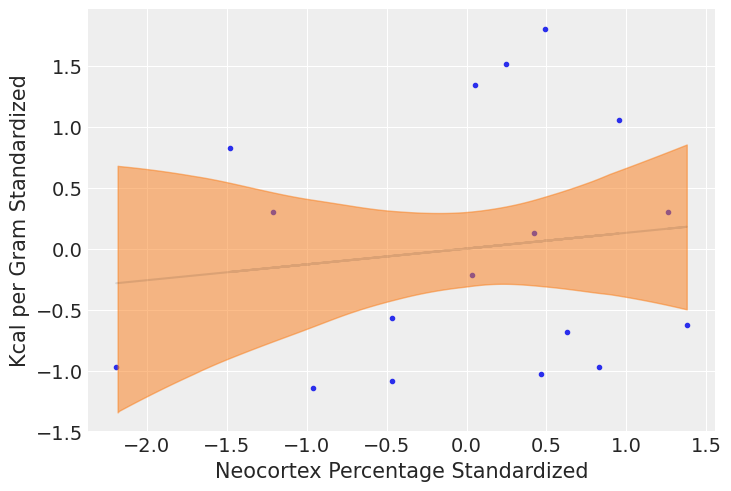

In [14]:
_, ax = plt.subplots(1, 1)

neocortex_stan = df['neocortex.perc_stan']
kcal_stan = df['kcal.per.g_stan']

ax.scatter(neocortex_stan, kcal_stan, marker='.')

ax.plot(neocortex_stan, mu_means, 'k-', alpha=0.1)

az.plot_hdi(neocortex_stan, np.expand_dims(df_mu.values, 0), ax=ax)

ax.set_xlabel('Neocortex Percentage Standardized')
ax.set_ylabel('Kcal per Gram Standardized')

plt.show()